# Localization

After achieving amazing result in classification. We are going to now do localization.

In [58]:
import os
import torch
import json
import torchvision
from PIL import Image
import numpy as np
import pandas as pd
from torch import nn
from torch import optim
from skimage import io, transform
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.utils.data import Dataset
from collections import OrderedDict
from torchvision import datasets, transforms, models
from torch.utils.data.sampler import SubsetRandomSampler

## Loading and Pre-processing the data

Again we are using the same dataset we used for classifiaction. It has 61 Images. I have labeled all images using lebelImg and annotations are stored in `annotations.json`

In [59]:
root_dir = '.'

Here we can't we `ImageFolder` or some other inbuilt datasets class so we have to write a custom dataset classs.

Let's see how our annotations look

In [60]:
with open('annotations.json') as f:
    json_file = json.load(f)

In [61]:
json_file[3]

{'annotations': [{'xmin': 363, 'ymin': 53, 'xmax': 750, 'ymax': 371}],
 'class': 'spill',
 'file': 'cup_data/spill/2019-06-11-171929_9.jpg'}

In [74]:
class CupDataset(Dataset):
    """Cup Dataset"""
    
    def __init__(self, json_file, root_dir, transform=None):
        self.anno = pd.read_json(json_file)
        self.anno = self.anno.set_index('file')
        self.root_dir = root_dir
        self.transform = transform
        
    def __len__(self):
        return len(self.anno)
    
    def __getitem__(self, idx):
        img_name = self.anno.iloc[idx].name
        img_path = os.path.join(self.root_dir, img_name)
        image = io.imread(img_path)
        d = self.anno.loc[img_name].annotations[0]
        xmin, ymin, xmax, ymax = d['xmin'], d['ymin'], d['xmax'], d['ymax']
        bb_cords = np.array([xmin, ymin, xmax, ymax])
        sample = {'image': image, 'bb_cords': bb_cords}
        
        if self.transform:
            sample  = self.transform(sample)
        return sample

### Transforms

We have to transform image as well as bounding box cordinates

In [99]:
class Resize(object):
    """Resize the image in a sample to a given size.

    Args:
        output_size (tuple or int): Desired output size. If tuple, output is
            matched to output_size. If int, smaller of image edges is matched
            to output_size keeping aspect ratio the same.
    """
    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size
        
    def __call__(self, sample):
        image, bb_cords = sample['image'], sample['bb_cords']
        
        h, w = image.shape[:2]
        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w / h   
        else:
            new_h, new_w = self.output_size
            
        new_h, new_w = int(new_h), int(new_w)
        
        img = transform.resize(image, (new_h, new_w))
        
        bb_cords[0::2] = bb_cords[0::2] * (new_w / w)
        bb_cords[1::2] = bb_cords[1::2] * (new_h / h)
#         bb_cords = bb_cords * [new_w / w, new_h / h]
        
        return {'image': img, 'bb_cords': bb_cords}

In [100]:
class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        image, bb_cords = sample['image'], sample['bb_cords']

        # swap color axis because
        # numpy image: H x W x C
        # torch image: C X H X W
        image = image.transpose((2, 0, 1))
        return {'image': torch.from_numpy(image),
                'bb_cords': torch.from_numpy(bb_cords)}

In [144]:
#transforms
tfms = transforms.Compose([Resize((224,224)), ToTensor()])

In [145]:
cup_dataset = CupDataset(json_file='annotations.json', root_dir='.', transform=tfms)

In [154]:
cup_dataset[0]['bb_cords']

tensor([110,  52, 163, 138])

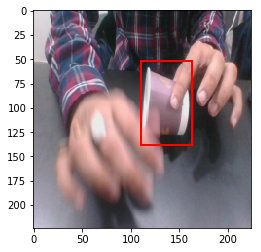

In [160]:
plt.imshow(cup_dataset[0]['image'].numpy().transpose((1, 2, 0)))
ax = plt.gca()
rect = Rectangle((110,52),53,138-52,linewidth=2,edgecolor='r',facecolor='none')
ax.add_patch(rect)

In [163]:
# function for drawing bounding box
from matplotlib.patches import Rectangle
def draw_bb(image, bb_cords, kind='numpy'):
    if kind == 'tensor':
        image = image.numpy().transpose((1, 2, 0))
    plt.imshow(image)
    # get current axis
    ax = plt.gca()
    b = bb_cords
    # (xmin, ymin), xmax-xmin, ymax-ymin
    rect = Rectangle((b[0],b[1]),b[2]-b[0],b[3]-b[1],linewidth=2,edgecolor='r',facecolor='none')
    ax.add_patch(rect)

0 torch.Size([3, 224, 224]) torch.Size([4])
1 torch.Size([3, 224, 224]) torch.Size([4])
2 torch.Size([3, 224, 224]) torch.Size([4])
3 torch.Size([3, 224, 224]) torch.Size([4])


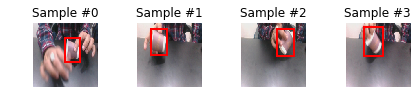

In [165]:
fig = plt.figure()
for i in range(len(cup_dataset)):
    sample = cup_dataset[i]
    
    print(i, sample['image'].shape, sample['bb_cords'].shape)
    
    ax = plt.subplot(1, 4, i + 1)
    plt.tight_layout()
    ax.set_title('Sample #{}'.format(i))
    ax.axis('off')
    draw_bb(**sample, kind='tensor')

    if i == 3:
        plt.show()
        break

In [140]:
len(cup_dataset)

61

In [167]:
# split data in train and validaion
bs=4
validation_split = .2
shuffle_dataset = True
random_seed= 42

dataset_size = len(cup_dataset)
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))
if shuffle_dataset:
    np.random.seed(random_seed)
    np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]

# Creating data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)

train_loader = torch.utils.data.DataLoader(cup_dataset, batch_size=bs, 
                                           sampler=train_sampler)
validation_loader = torch.utils.data.DataLoader(cup_dataset, batch_size=bs,
                                                sampler=valid_sampler)

13